In [1]:
import os

import pystablemotifs.random_boolean_networks as rbn

N_NODES_LIST = [10]
GRAPHS_PER_SIZE = 100
# For K=2, use p=0.5, for K=3, use p=0.211325
K = 3  # in-degree
p = 0.211325 # ratio of 1 in the truth table
DIRECTORY = "models/random_nk3"

for N_NODES in N_NODES_LIST:
    rules_list = rbn.random_boolean_network_ensemble_kauffman(N_NODES,K,p,GRAPHS_PER_SIZE,seed=1000)

    for i in range(GRAPHS_PER_SIZE):
        rules = rules_list[i]
        
        rules = rules.replace(" *=", ",")
        rules = rules.replace(" and ", " & ")
        rules = rules.replace(" or ", " | ")
        rules = rules.replace("not ", "!")

        writePath = DIRECTORY + f"/n{N_NODES:03}_{i:03}.bnet"
        isExist = os.path.exists(DIRECTORY)
        if not isExist:
            os.makedirs(DIRECTORY)

        with open(writePath, "w") as f:
            f.write("targets, factors\n")
            f.write(rules)

In [2]:
import numpy as np
from tqdm.autonotebook import tqdm

from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.state_transition_graphs import primes2stg
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.trap_spaces import compute_trap_spaces

from transition_matrix import get_transition_matrix, get_uniform_matrix
from matrix_operations import compress_matrix, expand_matrix
from matrix_operations import nsquare
from matrix_operations import get_rms_diff, get_dkl
from matrix_operations import get_reachability
from grouping import sd_grouping, null_grouping, random_grouping


def get_data(bnet, update="asynchronous", num_runs=100, DEBUG = False):

    data  = {"general":{}, "rmsd":{}, "dkl":{}, "reach":{}}

    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}

    data["general"]["N"] = len(primes)

    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        data["general"]["N_perc"] = 0
        data["general"]["min_trap"] = 1
        data["general"]["Tm_size"] = None
        data["rmsd"]["Tm"] = None
        data["dkl"]["Tm"] = None
        data["rmsd"]["Tm_inf"] = None
        data["dkl"]["Tm_inf"] = None
        data["general"]["T0_size"] = None
        data["rmsd"]["T0"] = None
        data["dkl"]["T0"] = None
        data["rmsd"]["T0_inf"] = None
        data["dkl"]["T0_inf"] = None
        data["rmsd"]["U"] = None
        data["dkl"]["U"] = None
        data["rmsd"]["U_inf"] = None
        data["dkl"]["U_inf"] = None
        data["rmsd"]["TR"] = None
        data["dkl"]["TR"] = None
        data["rmsd"]["TR_inf"] = None
        data["dkl"]["TR_inf"] = None
        return data

    percolated_bnet = primes2bnet(percolated_primes)

    data["general"]["N_perc"] = len(percolated_primes)

    # print(percolated_bnet)

    stg = primes2stg(percolated_primes, update)
    min_trap = compute_trap_spaces(percolated_primes, type_="min")

    data["general"]["min_trap"] = len(min_trap)

    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_inf = nsquare(T, 20, DEBUG=DEBUG)

    sd_indexes = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    sd_index_lengths = [len(sd_index) for sd_index in sd_indexes]

    data["general"]["sd_index_length_std"] = np.std(sd_index_lengths)

    Tm = compress_matrix(T, sd_indexes, DEBUG=DEBUG)
    Tm_prime = expand_matrix(Tm, sd_indexes, DEBUG=DEBUG)
    Tm_inf = nsquare(Tm, 20, DEBUG=DEBUG)
    Tm_inf_prime = expand_matrix(Tm_inf, sd_indexes, DEBUG=DEBUG)

    data["general"]["Tm_size"] = len([x for x in sd_indexes if x])
    data["rmsd"]["Tm"] = get_rms_diff(T, Tm_prime)
    data["dkl"]["Tm"] = get_dkl(T, Tm_prime)
    data["rmsd"]["Tm_inf"] = get_rms_diff(T_inf, Tm_inf_prime)
    data["dkl"]["Tm_inf"] = get_dkl(T_inf, Tm_inf_prime)

    data["reach"]["Tm"] = get_reachability(T, Tm_prime)
    data["reach"]["Tm_inf"] = get_reachability(T_inf, Tm_inf_prime)

    null_indexes = null_grouping(percolated_bnet, DEBUG=DEBUG)
    T0 = compress_matrix(T, null_indexes, DEBUG=DEBUG)
    T0_prime = expand_matrix(T0, null_indexes, DEBUG=DEBUG)
    T0_inf = nsquare(T0, 20, DEBUG=DEBUG)
    T0_inf_prime = expand_matrix(T0_inf, null_indexes, DEBUG=DEBUG)

    data["general"]["T0_size"] = len([x for x in null_indexes if x])
    data["rmsd"]["T0"] = get_rms_diff(T, T0_prime)
    data["dkl"]["T0"] = get_dkl(T, T0_prime)
    data["rmsd"]["T0_inf"] = get_rms_diff(T_inf, T0_inf_prime)
    data["dkl"]["T0_inf"] = get_dkl(T_inf, T0_inf_prime)

    data["reach"]["T0"] = get_reachability(T, T0_prime)
    data["reach"]["T0_inf"] = get_reachability(T_inf, T0_inf_prime)

    U = get_uniform_matrix(2**(len(percolated_primes)))

    data["rmsd"]["U"] = get_rms_diff(T, U)
    data["dkl"]["U"] = get_dkl(T, U)
    data["rmsd"]["U_inf"] = get_rms_diff(T_inf, U)
    data["dkl"]["U_inf"] = get_dkl(T_inf, U)

    data["reach"]["U"] = get_reachability(T, U)
    data["reach"]["U_inf"] = get_reachability(T_inf, U)

    rmsd = []
    dkl = []
    reach_TP = []
    reach_FP = []
    reach_TN = []
    reach_FN = []

    rmsd_inf = []
    dkl_inf = []
    reach_inf_TP = []
    reach_inf_FP = []
    reach_inf_TN = []
    reach_inf_FN = []


    data["general"]["random_index_length_std"] = []

    # for i in tqdm(range(num_runs), desc="Processing", unit="iteration", ncols=300, miniters=5):
    for i in range(num_runs):
        random_indexes = random_grouping(sd_indexes, null_indexes, seed=i, DEBUG=DEBUG)

        random_index_lengths = [len(random_index) for random_index in random_indexes]

        data["general"]["random_index_length_std"].append(np.std(random_index_lengths))

        TRm = compress_matrix(T, random_indexes, DEBUG=DEBUG)
        TRm_prime = expand_matrix(TRm, random_indexes, DEBUG=DEBUG)
        TRm_inf = nsquare(TRm, 20, DEBUG=DEBUG)
        TRm_inf_prime = expand_matrix(TRm_inf, random_indexes, DEBUG=DEBUG)
        
        rmsd.append(get_rms_diff(T, TRm_prime))
        dkl.append(get_dkl(T, TRm_prime))
        reach = get_reachability(T, TRm_prime)
        reach_TP.append(reach[0])
        reach_FP.append(reach[1])
        reach_TN.append(reach[2])
        reach_FN.append(reach[3])

        rmsd_inf.append(get_rms_diff(T_inf, TRm_inf_prime))
        dkl_inf.append(get_dkl(T_inf, TRm_inf_prime))
        reach_inf = get_reachability(T_inf, TRm_inf_prime)
        reach_inf_TP.append(reach_inf[0])
        reach_inf_FP.append(reach_inf[1])
        reach_inf_TN.append(reach_inf[2])
        reach_inf_FN.append(reach_inf[3])

    data["rmsd"]["TR"] = rmsd
    data["dkl"]["TR"] = dkl
    data["rmsd"]["TR_inf"] = rmsd_inf
    data["dkl"]["TR_inf"] = dkl_inf
    data["reach"]["TR_TP"] = reach_TP
    data["reach"]["TR_FP"] = reach_FP
    data["reach"]["TR_TN"] = reach_TN
    data["reach"]["TR_FN"] = reach_FN
    data["reach"]["TR_inf_TP"] = reach_inf_TP
    data["reach"]["TR_inf_FP"] = reach_inf_FP
    data["reach"]["TR_inf_TN"] = reach_inf_TN
    data["reach"]["TR_inf_FN"] = reach_inf_FN

    for key in ["rmsd", "dkl"]:
    # Calculate the mean and standard deviation
        mean = np.mean(data[key]["TR"])
        std_dev = np.std(data[key]["TR"])

        # Calculate the Z-score of the reference number
        if data[key]["Tm"] != data[key]["T0"]:
            z_score = (data[key]["Tm"] - mean) / std_dev
        else:
            z_score = np.nan

        data[key]["Tm_z"] = z_score

        mean = np.mean(data[key]["TR_inf"])
        std_dev = np.std(data[key]["TR_inf"])

        # Calculate the Z-score of the reference number
        if data[key]["Tm_inf"] != data[key]["T0_inf"]:
            z_score = (data[key]["Tm_inf"] - mean) / std_dev
        else:
            z_score = np.nan

        data[key]["Tm_inf_z"] = z_score

    return data

/tmp/ipykernel_68194/3069444595.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# read files from DIRECTORY
import os

# Set the directory path
directory_path = "models/random_nk3"

all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(directory_path)):

    # if filename == "n010_006.bnet" or filename == "n010_007.bnet":
    #     continue

    # if filename != "n010_006.bnet":
    #     continue

    file_path = os.path.join(directory_path, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
    
    # print(content)
    
    data = get_data(bnet=content, update="synchronous", num_runs=100, DEBUG=True)

    all_data[filename] = data

    # print(f"{data["dkl"]["Tm"]=}")
    # print(f"{data["dkl"]["Tm_inf"]=}")
    # print(f"{data["dkl"]["T0"]=}")
    # print(f"{data["dkl"]["T0_inf"]=}")

    # break



Reading file: n010_000.bnet
Reading file: n010_001.bnet


/home/kyuhyongpark/SDMarkov/sdmarkov/matrix_operations.py:416: RuntimeWarning: divide by zero encountered in divide
  ratio = np.divide(A,B, out=np.zeros_like(A, dtype=float), where=A!=0.0)
/home/kyuhyongpark/SDMarkov/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
sd_nodes=[{}, {'n2': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 1, 'n8': 1, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 1, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 1, 'n1': 1, 'n2': 0, 'n3': 0, 'n4': 1, 'n5': 1, 'n6': 0, 'n8': 0, 'n9': 0}]
sd_edges=[[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}], [{'n2': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n2': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}], [{'n0': 0, 'n2': 1, 'n6': 0, 'n8': 0}], [{'n0': 0, 'n1': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n9': 0}], [{

/home/kyuhyongpark/SDMarkov/sdmarkov/matrix_operations.py:416: RuntimeWarning: overflow encountered in divide
  ratio = np.divide(A,B, out=np.zeros_like(A, dtype=float), where=A!=0.0)


Reading file: n010_028.bnet
Reading file: n010_029.bnet
sd_nodes=[{}, {'n0': 1, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n9': 0}, {'n0': 1, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n9': 0}, {'n0': 1, 'n1': 1, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n9': 0}]
sd_edges=[[{'n2': 0, 'n3': 0, 'n4': 0, 'n9': 0}], [{'n0': 1, 'n1': 1, 'n4': 0, 'n9': 0}]]
Duplicate state: 1100010
SD edge: [{'n2': 0, 'n3': 0, 'n4': 0, 'n9': 0}]
SD edge: [{'n0': 1, 'n1': 1, 'n4': 0, 'n9': 0}]
duplicates={'1100010': [[{'n2': 0, 'n3': 0, 'n4': 0, 'n9': 0}], [{'n0': 1, 'n1': 1, 'n4': 0, 'n9': 0}]]}
extra_groups=[{'n0': 1, 'n1': 1, 'n2': 0, 'n3': 0, 'n4': 0, 'n9': 0}]
Reading file: n010_030.bnet
Reading file: n010_031.bnet
sd_nodes=[{}, {'n3': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 1, 'n7': 1, 'n9': 0}]
sd_edges=[[{'n9': 0}], [{'n0': 0, 'n3': 0, 'n5': 0, 'n6': 1, 'n7': 1, 'n9': 0}, {'n0': 0, 'n1': 0, 'n3': 0, 'n7': 1, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n9': 0}], [{'n0': 0,

/tmp/ipykernel_68194/3069444595.py:187: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (data[key]["Tm_inf"] - mean) / std_dev


Reading file: n010_084.bnet
Reading file: n010_085.bnet
Reading file: n010_086.bnet
Reading file: n010_087.bnet
Reading file: n010_088.bnet
Reading file: n010_089.bnet
Reading file: n010_090.bnet
Reading file: n010_091.bnet
sd_nodes=[{}, {'n9': 0}, {'n6': 0, 'n7': 0, 'n8': 0}, {'n5': 1, 'n6': 0, 'n7': 0, 'n8': 0}, {'n2': 0, 'n5': 0, 'n6': 0, 'n7': 0}, {'n2': 0, 'n5': 0, 'n6': 0, 'n7': 0, 'n8': 0}, {'n2': 0, 'n4': 1, 'n6': 0, 'n7': 0, 'n9': 0}, {'n2': 0, 'n4': 1, 'n6': 0, 'n7': 0, 'n8': 0, 'n9': 0}, {'n2': 0, 'n4': 1, 'n5': 0, 'n6': 0, 'n7': 0, 'n9': 0}, {'n2': 0, 'n4': 1, 'n5': 0, 'n6': 0, 'n7': 0, 'n8': 0, 'n9': 0}, {'n2': 0, 'n4': 1, 'n5': 1, 'n6': 0, 'n7': 0, 'n9': 0}, {'n2': 0, 'n4': 1, 'n5': 1, 'n6': 0, 'n7': 0, 'n8': 0, 'n9': 0}, {'n1': 0, 'n3': 0}, {'n1': 0, 'n3': 0, 'n6': 0, 'n7': 0, 'n8': 0}, {'n1': 0, 'n3': 0, 'n5': 1, 'n6': 0, 'n7': 0, 'n8': 0}, {'n1': 0, 'n2': 0, 'n3': 0, 'n5': 0, 'n6': 0, 'n7': 0}, {'n1': 0, 'n2': 0, 'n3': 0, 'n5': 0, 'n6': 0, 'n7': 0, 'n8': 0}, {'n0': 1, 

In [4]:
for bnet in all_data:
    if all_data[bnet]["general"]["N_perc"] == 0:
        continue
    print(bnet,
          all_data[bnet]["general"]["N"],
          all_data[bnet]["general"]["N_perc"],
          all_data[bnet]["general"]["Tm_size"],
          all_data[bnet]["general"]["T0_size"],
          all_data[bnet]["rmsd"]["Tm"],
          np.mean(all_data[bnet]["rmsd"]["TR"]),
          all_data[bnet]["rmsd"]["T0"],
          all_data[bnet]["rmsd"]["U"],
          all_data[bnet]["dkl"]["Tm"],
          np.mean(all_data[bnet]["dkl"]["TR"]),
          all_data[bnet]["dkl"]["T0"],
          all_data[bnet]["dkl"]["U"],
          all_data[bnet]["rmsd"]["Tm_inf"],
          np.mean(all_data[bnet]["rmsd"]["TR_inf"]),
          all_data[bnet]["rmsd"]["T0_inf"],
          all_data[bnet]["rmsd"]["U_inf"],
          all_data[bnet]["dkl"]["Tm_inf"],
          np.mean(all_data[bnet]["dkl"]["TR_inf"]),
          all_data[bnet]["dkl"]["T0_inf"],
          all_data[bnet]["dkl"]["U_inf"],
          )

n010_000.bnet 10 10 16 3 0.028062550949431816 0.028069812350764334 0.028248139655979748 0.02828122302312245 4338.145694386315 4448.885268188392 6526.344131913046 6764.942164181 0.017175658799834532 0.017361278059563254 0.017364031141729023 0.01801574752867411 2423.934580870776 2803.4870431969266 2808.6478729941373 5972.8481453376935
n010_001.bnet 10 6 12 6 0.09475330307353982 0.09528573320774825 0.10053477629720056 0.10635717633678196 142.33884635587117 131.04175259832155 214.33727553836158 239.13484480304075 0.07574499777213015 0.09344479027496788 0.09522344183008163 0.109375 48.520302639196174 inf inf 241.21521883486096
n010_002.bnet 10 7 5 2 0.07509099467460567 0.07520878810379089 0.07609961975979163 0.07650586201613332 432.1894244441634 441.34819374879675 563.1017665562815 568.975101359083 0.05036218647347323 0.07654655446197434 0.07654655446197431 0.07614683081882002 233.94812522041954 inf inf 576.6984542258745
n010_003.bnet 10 10 3 2 0.028251815477907775 0.028253751794021845 0.02

In [5]:
for bnet in all_data:
    if all_data[bnet]["general"]["N_perc"] == 0:
        continue
    print(bnet,
          all_data[bnet]["rmsd"]["Tm_z"],
          all_data[bnet]["dkl"]["Tm_z"],
          all_data[bnet]["rmsd"]["Tm_inf_z"],
          all_data[bnet]["dkl"]["Tm_inf_z"],
          all_data[bnet]["general"]["min_trap"],
          all_data[bnet]["general"]["sd_index_length_std"],
          np.mean(all_data[bnet]["general"]["random_index_length_std"]),
          )

n010_000.bnet -25.78434243266096 -21.032298600457924 -26.768938309314798 -35.18971092915863 2 36.259694318882026 14.034287205857174
n010_001.bnet -7.118848974237841 6.510230381531187 -16.49711495438319 nan 5 7.523001764957626 4.016746516444015
n010_002.bnet -8.077781269946877 -3.3242952204973015 -943391279327564.2 nan 1 19.043108989868223 13.079940822220797
n010_003.bnet -19.92653989417343 5.4542040339842295 nan nan 1 319.02176867557 240.97476841633107
n010_004.bnet -22.32531232463054 116.35301132529219 -36.993158510880114 nan 4 45.97270707624652 9.06555326767599
n010_005.bnet nan nan nan nan 1 0.0 0.0
n010_006.bnet -27.91920626592566 75.53997161527681 -10.219712449177312 -7.0279607377151105 2 70.19150997494184 18.183839898537517
n010_007.bnet -18.371978901403253 6.234248825799549 3.4456019884623483 nan 2 22.23670196156399 10.178663612642312
n010_008.bnet -14.282267093924391 0.48875789430960237 -47.602919778187236 -52.60188323439433 3 39.633525285175075 33.34647992368737
n010_009.bnet 

In [6]:
for bnet in all_data:
    if all_data[bnet]["general"]["N_perc"] == 0:
        continue
    print(bnet,
          all_data[bnet]["reach"]["Tm"][0],
          all_data[bnet]["reach"]["Tm"][1],
          all_data[bnet]["reach"]["Tm"][2],
          all_data[bnet]["reach"]["Tm"][3],
          np.mean(all_data[bnet]["reach"]["TR_TP"]),
          np.mean(all_data[bnet]["reach"]["TR_FP"]),
          np.mean(all_data[bnet]["reach"]["TR_TN"]),
          np.mean(all_data[bnet]["reach"]["TR_FN"]),
          all_data[bnet]["reach"]["T0"][0],
          all_data[bnet]["reach"]["T0"][1],
          all_data[bnet]["reach"]["T0"][2],
          all_data[bnet]["reach"]["T0"][3],
          all_data[bnet]["reach"]["U"][0],
          all_data[bnet]["reach"]["U"][1],
          all_data[bnet]["reach"]["U"][2],
          all_data[bnet]["reach"]["U"][3],
          all_data[bnet]["reach"]["Tm_inf"][0],
          all_data[bnet]["reach"]["Tm_inf"][1],
          all_data[bnet]["reach"]["Tm_inf"][2],
          all_data[bnet]["reach"]["Tm_inf"][3],
          np.mean(all_data[bnet]["reach"]["TR_inf_TP"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_FP"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_TN"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_FN"]),
          all_data[bnet]["reach"]["T0_inf"][0],
          all_data[bnet]["reach"]["T0_inf"][1],
          all_data[bnet]["reach"]["T0_inf"][2],
          all_data[bnet]["reach"]["T0_inf"][3],
          all_data[bnet]["reach"]["U_inf"][0],
          all_data[bnet]["reach"]["U_inf"][1],
          all_data[bnet]["reach"]["U_inf"][2],
          all_data[bnet]["reach"]["U_inf"][3],
          )

n010_000.bnet 2048 212992 833536 0 2048.0 887521.58 159006.42 0.0 2048 983040 63488 0 2048 1046528 0 0 3072 29696 1015808 0 3072.0 60416.0 985088.0 0.0 3072 60416 985088 0 3072 1045504 0 0
n010_001.bnet 124 1256 2716 0 124.0 2091.22 1880.78 0.0 124 3596 376 0 124 3972 0 0 116 182 3798 0 52.0 298.07 3681.93 64.0 52 304 3676 64 116 3980 0 0
n010_002.bnet 255 8946 7183 0 255.0 15664.9 464.1 0.0 255 16002 127 0 255 16129 0 0 192 4496 11696 0 64.0 64.0 16128.0 128.0 64 64 16128 128 192 16192 0 0
n010_003.bnet 2047 848898 197631 0 2047.0 1045506.0 1023.0 0.0 2047 1045506 1023 0 2047 1046529 0 0 880 144 1047264 288 880.0 144.0 1047264.0 288.0 880 144 1047264 288 1168 1047408 0 0
n010_004.bnet 1020 130850 130274 0 1020.0 142367.94 118756.06 0.0 1020 259080 2044 0 1020 261124 0 0 488 720 260888 48 488.0 1533.39 260074.61 48.0 488 1548 260060 48 536 261608 0 0
n010_005.bnet 128 3968 0 0 128.0 3968.0 0.0 0.0 128 3968 0 0 128 3968 0 0 364 3732 0 0 364.0 3732.0 0.0 0.0 364 3732 0 0 364 3732 0 0
n01

Figure where min_max is between sd and null (or max of the randoms)

In [7]:
import matplotlib.pyplot as plt

def plot_histogram1(data, title, xmax_rmsd=0.18, xmax_dkl=80, ymax=0.5):
    randoms = [np.array(data["rmsd"]["TR"]),
            np.array(data["dkl"]["TR"]),
            np.array(data["rmsd"]["TR_inf"]),
            np.array(data["dkl"]["TR_inf"])]

    sds = [data["rmsd"]["Tm"],
        data["dkl"]["Tm"],
        data["rmsd"]["Tm_inf"],
        data["dkl"]["Tm_inf"]]

    nulls = [data["rmsd"]["T0"],
            data["dkl"]["T0"],
            data["rmsd"]["T0_inf"],
            data["dkl"]["T0_inf"]]

    # print(sds)
    # print(nulls)

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 4))

    # Loop over each dataset and corresponding reference value
    for i, (ran, sd, null) in enumerate(zip(randoms, sds, nulls)):
        row, col = divmod(i, 2)  # Determine subplot position
        ax = axs[row, col]

        # Calculate the mean and standard deviation
        mean = np.mean(ran)
        std_dev = np.std(ran)

        # Calculate the Z-score of the reference number
        if sd != null:
            z_score = (sd - mean) / std_dev
        else:
            z_score = np.nan

        # binwidth = xmax_rmsd/100
        # if i == 1 or i == 3:
        #     binwidth = xmax_dkl/100

        # Create the histogram
        # hist, bins = np.histogram(ran, bins=np.arange(min(ran), max(ran) + binwidth, binwidth))
        hist, bins = np.histogram(ran, bins=10)

        # Calculate the ratio
        ratio = hist / hist.sum()

        if i == 2 or i == 3:
            inf = "∞"
        else:
            inf = ""

        # Plot histogram and reference line
        ax.bar(bins[:-1], ratio, width=np.diff(bins), align='edge', alpha=0.7)
        ax.axvline(sd, color='red', linestyle='-', linewidth=1, label=f'Tm{inf} (Z-score = {z_score:.2f})')
        ax.axvline(null, color='black', linestyle='-', linewidth=1, label='Null')
        # Adding lines for mean
        ax.axvline(mean, color='blue', linestyle='--', linewidth=1, label='Mean')

        # Set the labels, limits, and legend for each subplot
        ax.set_xlabel('Value')
        ax.set_ylabel('Ratio')
        # ax.set_ylim(0, ymax)
        ax.legend()

    axs[0,0].set_title("RMSD")
    axs[0,1].set_title("Dkl")
    axs[1,0].set_title("RMSD_inf")
    axs[1,1].set_title("Dkl_inf")

    # axs[0,0].set_xlim(-xmax_rmsd/100, xmax_rmsd)
    # axs[0,1].set_xlim(-xmax_dkl/100, xmax_dkl)
    # axs[1,0].set_xlim(-xmax_rmsd/100, xmax_rmsd)
    # axs[1,1].set_xlim(-xmax_dkl/100, xmax_dkl)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.suptitle(title)

    # Show the plot
    plt.show()

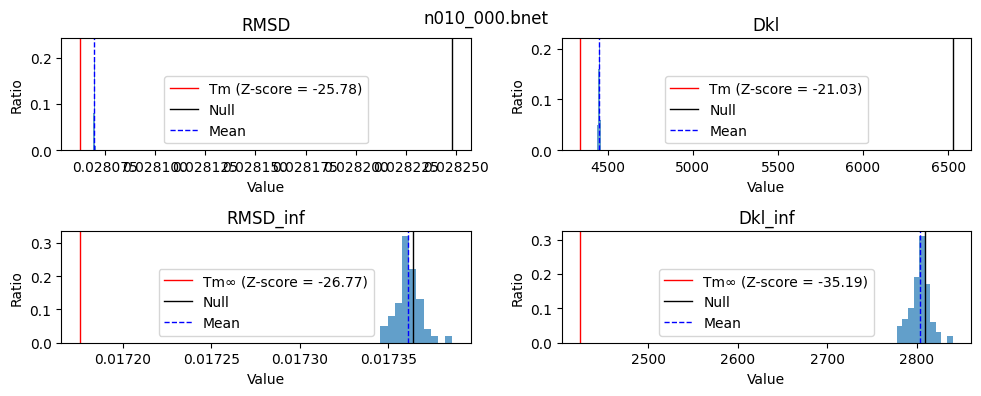

ValueError: autodetected range of [inf, inf] is not finite

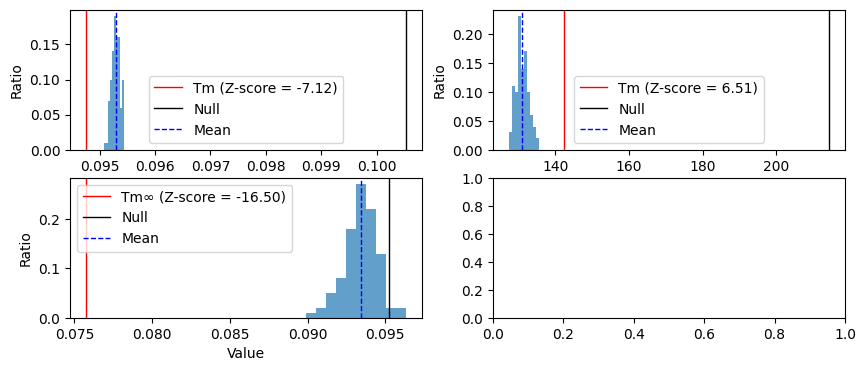

In [8]:
for i, bnet in enumerate(all_data):
    if i == 5:
        break
    plot_histogram1(all_data[bnet], title=bnet)


Figure where min_max is between sd and uniform

In [9]:
import matplotlib.pyplot as plt

def plot_histogram2(data, title, xmin=None, xmax_rmsd=0.18, xmax_dkl=80, ymax=0.5):
    randoms = [np.array(data["rmsd"]["TR"]),
            np.array(data["dkl"]["TR"]),
            np.array(data["rmsd"]["TR_inf"]),
            np.array(data["dkl"]["TR_inf"])]

    sds = [data["rmsd"]["Tm"],
        data["dkl"]["Tm"],
        data["rmsd"]["Tm_inf"],
        data["dkl"]["Tm_inf"]]

    nulls = [data["rmsd"]["T0"],
            data["dkl"]["T0"],
            data["rmsd"]["T0_inf"],
            data["dkl"]["T0_inf"]]

    uniforms = [data["rmsd"]["U"],
            data["dkl"]["U"],
            data["rmsd"]["U_inf"],
            data["dkl"]["U_inf"]]

    # print(sds)
    # print(nulls)

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 4))

    # Loop over each dataset and corresponding reference value
    for i, (ran, sd, null, uniform) in enumerate(zip(randoms, sds, nulls, uniforms)):
        row, col = divmod(i, 2)  # Determine subplot position
        ax = axs[row, col]

        # Calculate the mean and standard deviation
        mean = np.mean(ran)
        std_dev = np.std(ran)

        # Calculate the Z-score of the reference number
        if sd != null:
            z_score = (sd - mean) / std_dev
        else:
            z_score = np.nan

        # binwidth = xmax_rmsd/100
        # if i == 1 or i == 3:
        #     binwidth = xmax_dkl/100

        # Create the histogram
        # hist, bins = np.histogram(ran, bins=np.arange(min(ran), max(ran) + binwidth, binwidth))
        hist, bins = np.histogram(ran, bins=10)

        # Calculate the ratio
        ratio = hist / hist.sum()

        if i == 2 or i == 3:
            inf = "∞"
        else:
            inf = ""

        # Plot histogram and reference line
        ax.bar(bins[:-1], ratio, width=np.diff(bins), align='edge', alpha=0.7)
        ax.axvline(sd, color='red', linestyle='-', linewidth=1, label=f'Tm{inf} (Z-score = {z_score:.2f})')
        ax.axvline(null, color='black', linestyle='-', linewidth=1, label='Null')
        ax.axvline(uniform, color='purple', linestyle='-', linewidth=1, label='Uniform')
        # Adding lines for mean
        ax.axvline(mean, color='blue', linestyle='--', linewidth=1, label='Mean')

        # Set the labels, limits, and legend for each subplot
        ax.set_xlabel('Value')
        ax.set_ylabel('Ratio')
        # ax.set_ylim(0, ymax)
        ax.legend()

        if xmin != None:
            ax.set_xlim(left=xmin)

    axs[0,0].set_title("RMSD")
    axs[0,1].set_title("Dkl")
    axs[1,0].set_title("RMSD_inf")
    axs[1,1].set_title("Dkl_inf")

    # axs[0,0].set_xlim(-xmax_rmsd/100, xmax_rmsd)
    # axs[0,1].set_xlim(-xmax_dkl/100, xmax_dkl)
    # axs[1,0].set_xlim(-xmax_rmsd/100, xmax_rmsd)
    # axs[1,1].set_xlim(-xmax_dkl/100, xmax_dkl)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.suptitle(title)

    # Show the plot
    plt.show()

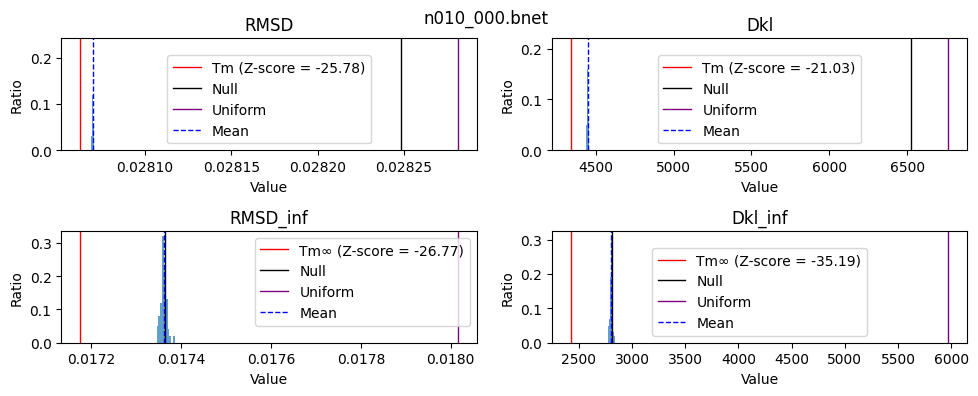

ValueError: autodetected range of [inf, inf] is not finite

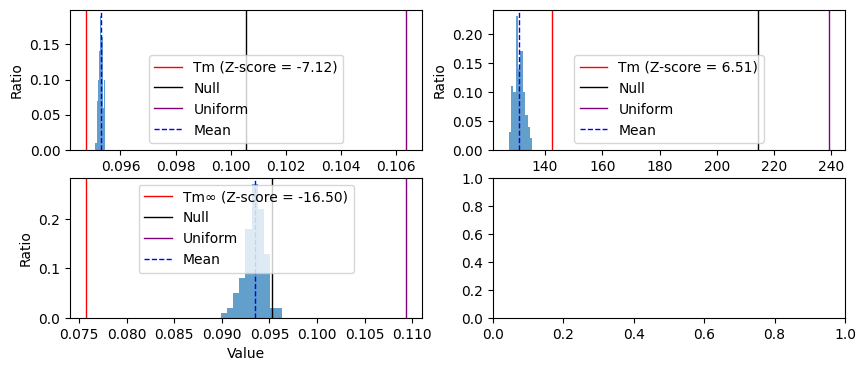

In [10]:
for i, bnet in enumerate(all_data):
    if i == 5:
        break
    plot_histogram2(all_data[bnet], title=bnet)

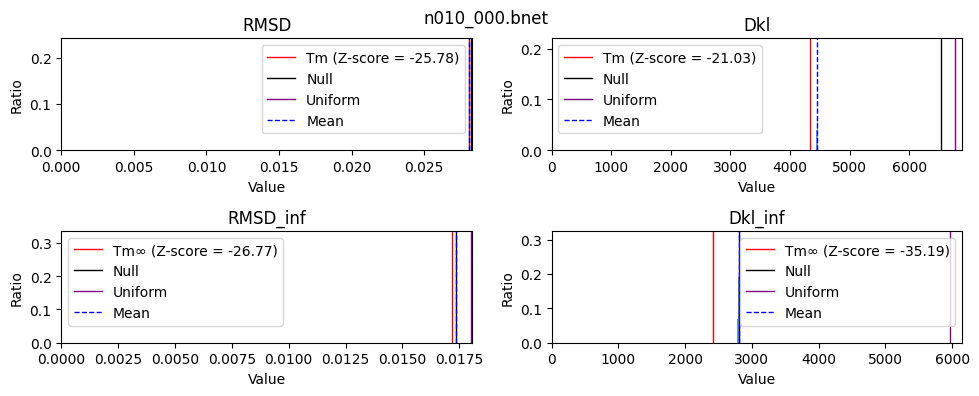

ValueError: autodetected range of [inf, inf] is not finite

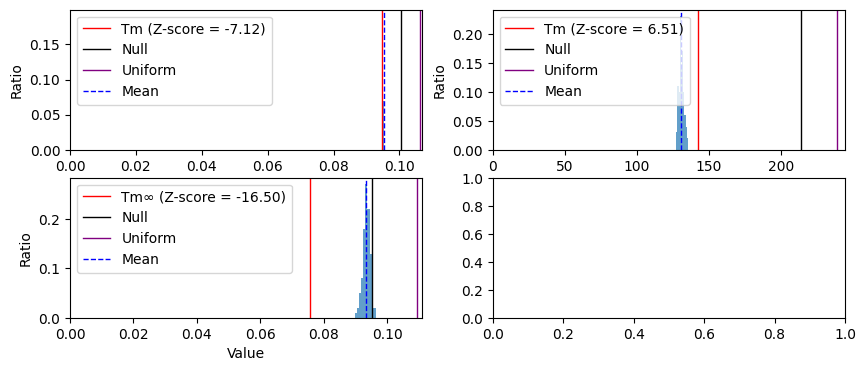

In [11]:
for i, bnet in enumerate(all_data):
    if i == 5:
        break
    plot_histogram2(all_data[bnet], title=bnet, xmin=0)